In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt


def route_image(list_cities, route):
    for i in range(list_cities.shape[0]):
        plt.annotate(i, (list_cities[i][0], list_cities[i][1]), fontsize=14)
    plt.scatter(list_cities[:, 0], list_cities[:, 1], c='red')
    x = [list_cities[route[-1]][0]]
    y = [list_cities[route[-1]][1]]
    for i in range(len(route)):
        x.append(list_cities[route[i]][0])
        y.append(list_cities[route[i]][1])
    plt.plot(x, y, c='blue')
    plt.show()


def route_length(list_cities, route):
    length_penalty = 0
    length = 0
    for i in range(len(list_cities) - 1):
        if i not in route:
            length_penalty += 10
    for j in range(route.size - 1):
        sum = 0
        for xy in range(2):
            sum += (list_cities[route[j]][xy] - list_cities[route[j + 1]][xy]) ** 2
        length += sum ** (1 / 2)

    sum = 0
    for xy in range(2):
        sum += (list_cities[route[0]][xy] - list_cities[route[-1]][xy]) ** 2
    length += sum ** (1 / 2)
    # print("penal = |", length_penalty, "|\n len = |", length, "|\n")
    return length + length_penalty


def quality(list_cities, routes):
    # проведем оценку маршрутов
    length_penalty = np.zeros([len(routes)])
    for i in range(len(routes)):
        length_penalty[i] = route_length(list_cities, routes[i])

    return length_penalty


def generate_routes(number_cities, number_routes):
    list_cities = np.random.random([number_cities, 2])  # координаты городов
    routes = []
    for i in range(number_routes):
        routes.append(np.random.permutation(number_cities))
    routes = np.array(routes)
    return routes, list_cities


def mutation(list_cities, routes, count_permit, count_routes, detla, max_iteration):
    new_routes, arr_len = selection_routes(list_cities, routes, count_routes)

    new_arr_len = np.zeros(len(arr_len))

    for i in range(len(new_routes) - 1):
        new_route = permit_routes(routes[i], count_permit)
        new_arr_len[i] = route_length(list_cities, new_route)
        count = 0
        while arr_len[i] - detla < new_arr_len[i] and count < max_iteration:
            new_route = permit_routes(routes[i], count_permit)
            new_arr_len[i] = route_length(list_cities, new_route)
            count += 1
        routes[i] = new_route

    routes, sort_arr = selection_routes(list_cities, routes, count_routes)

    return routes, sort_arr


def permit_routes(route, count_permit):
    for i in range(count_permit):
        num_city_1 = random.randint(0, len(route) - 1)
        num_city_2 = random.randint(0, len(route) - 1)
        while num_city_1 == num_city_2:
            num_city_2 = random.randint(0, len(route) - 1)
        index_1 = np.where(route == num_city_1)
        index_2 = np.where(route == num_city_2)

        route[index_1] = num_city_2
        route[index_2] = num_city_1

    return route


def clear_routes_with_penalty(list_cities, routes):
    new_routes = []
    for j in range(len(routes) - 1):
        i = 0
        flag = True
        while i > len(list_cities) - 1 and flag:
            if i not in routes[j]:
                flag = False
            i += 1
        if flag:
            new_routes.append(routes[j])

    new_routes = np.array(new_routes)
    return new_routes


def index_permit(count_permit, count_cities):
    arr_index = np.zeros(count_permit, dtype=int)
    for i in range(count_permit):
        arr_index[i] = -1
    i = 0
    while i < count_permit:
        index = random.randint(0, count_cities)
        if index not in arr_index:
            arr_index[i] = index
            i += 1
    return arr_index


def sort_routes(list_cities, routes):
    unsort_dict = {}
    arr_len = np.zeros(len(routes))
    for i in range(len(routes)):
        arr_len[i] = route_length(list_cities, routes[i])
        a = {arr_len[i]: routes[i]}
        unsort_dict.update(a)

    sort_arr = np.sort(arr_len)
    sorted_dict = {k: unsort_dict[k] for k in sorted(unsort_dict)}

    return sorted_dict, sort_arr


def selection_routes(list_cities, routes, count_routes):
    sorted_dict, arr_len = sort_routes(list_cities, routes)
    new_routes = np.zeros((count_routes, len(list_cities)), dtype=int)
    for i in range(count_routes):
        new_routes[i] = sorted_dict.get(arr_len[i])
    return new_routes, arr_len


def crossbreeding(list_cities, routes, count_routes, count_insert, delta, max_iteration):
    new_routes, arr_len = selection_routes(list_cities, routes, count_routes)
    cros_route = []
    for i in range(len(new_routes) - 1):
        for j in range(len(new_routes) - 1):
            count = 0
            new_route = insert_route(new_routes[i], new_routes[j], count_insert)
            new_len = route_length(list_cities, new_route)
            while arr_len[i] - delta < new_len and count < max_iteration:
                new_route = insert_route(new_routes[i], new_routes[j], count_insert)
                new_len = route_length(list_cities, new_route)
                count += 1
            cros_route.append(new_route)
    cros_route = np.array(cros_route)
    cros_route, cros_len = selection_routes(list_cities, cros_route, len(cros_route))

    return cros_route, cros_len


def insert_route(route_1, route_2, count_insert):
    start_index = random.randint(0, len(route_1) - count_insert - 1)
    arr_insert = np.zeros(count_insert, dtype=int)
    route_3 = np.zeros(len(route_1), dtype=int)
    for i in range(count_insert):
        arr_insert[i] = route_1[i + start_index]
    for j in range(len(route_1) - count_insert):
        arr_part = np.zeros(count_insert, dtype=int)
        insert_index = j
        for k in range(count_insert):
            arr_part[k] = route_2[k + j]
        intersection = np.array(list(set(arr_insert) & set(arr_part)))
        if len(intersection) == count_insert and (compare(intersection, arr_insert) == False):
            route_3 = insert_arr(route_2, arr_insert, insert_index, count_insert)

    route_4 = np.zeros(len(route_1), dtype=int)
    if (route_3.all() == route_4.all()):
        route_3 = route_2
    return route_3


def compare(arr_1, arr_2):
    flag = False
    range_ = len(arr_1) if len(arr_1) < len(arr_2) else len(arr_2)
    count = 0
    for i in range(range_):
        if arr_1[i] == arr_2[i]:
            count += 1
    if count == range_:
        flag = True

    return flag


def insert_arr(route, arr_insert, index, count_insert):
    new_route = np.zeros(len(route), dtype=int)
    for j in range(len(route)):
        new_route[j] = route[j]

    for i in range(index, count_insert + index):
        new_route[i] = arr_insert[i - index]

    return new_route


In [5]:
def main():
    number_cities, number_routes = 15, 100
    routes, list_cities = generate_routes(number_cities, number_routes)
    count_permit = 1
    count_routes = int(number_routes / 4)
    delta = 0.2
    max_iter = 100
    count_insert = 5

    len_qu = quality(list_cities, routes)
    min = len_qu.min()
    index = list(len_qu).index(min)
    print("Route to mutation:   ", routes[index], " len :", min)
    route_image(list_cities, routes[index])

    mut_routes, arr_len = mutation(list_cities, routes, count_permit, count_routes, delta, max_iter)

    for i in range(1):
        print("Route to crossbreeding:", mut_routes[i], " len :", arr_len[i])
        route_image(list_cities, mut_routes[i])

    cros_route, cros_len = crossbreeding(list_cities, mut_routes, count_routes, count_insert, delta, max_iter)

    for i in range(1):
        print("Route after crossbreeding:", cros_route[i], " len :", cros_len[i])
        route_image(list_cities, cros_route[i])

    print("Ok")

Route to mutation:    [ 5  1 10 12  9 13  3  6  8  7  4  0 11 14  2]  len : 5.572398767703814


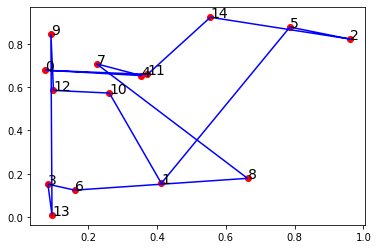

Route to crossbreeding: [ 5  1 10 12  9 13  3  6  8  7  4  0 11 14  2]  len : 5.572398767703814


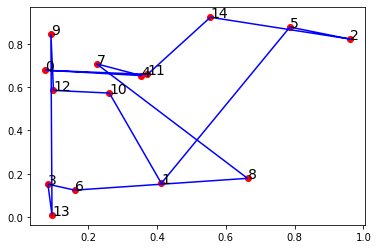

Route after crossbreeding: [ 5  1 10 12  9 13  3  6  8  7  4  0 11 14  2]  len : 5.572398767703814


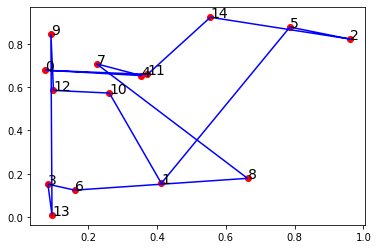

Ok


In [6]:
main()